In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)

from sgptools.utils.tsp import run_tsp # TSP/VRP solver for initial path planning
from sgptools.kernels import get_kernel
from sgptools.kernels.attentive import *
from sgptools.utils.gpflow import get_model_params
from sgptools.utils.data import Dataset

np.random.seed(1234)
tf.random.set_seed(1234)

/home/itskalvik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-11-23 10:54:06.554919: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 10:54:06.559644: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 10:54:06.588864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 10:54:06.633303: E ex

In [2]:
# Method to extract lengthscales map from attentive non stationary kernel
def predict_lengthscales(X, lengthscales, kernel):
        preds = np.zeros(len(X))
        repre1 = kernel.get_representations(X)
        for i in range(len(lengthscales)):
                attention = tf.tensordot(repre1[:, i],
                                         tf.transpose(repre1[:, i]),
                                         axes=0)
                preds += np.diag(attention) * lengthscales[i]
        return preds

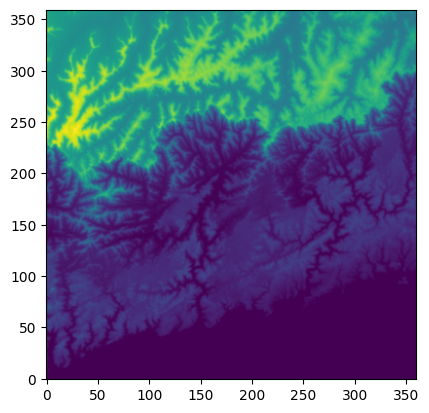

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (20000, 2), (20000, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.


2025-11-23 10:54:16.071886: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Load data
data = np.load("N17E073.npy")
plt.imshow(data.T, origin="lower")
plt.show()

dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000, num_test=20000)
X_train, y_train = dataset.get_train()

# Train GP/Kernel 
lengthscales = np.linspace(1, 10, 10)
_, noise_variance, kernel, model = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(lengthscales=lengthscales),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=False)

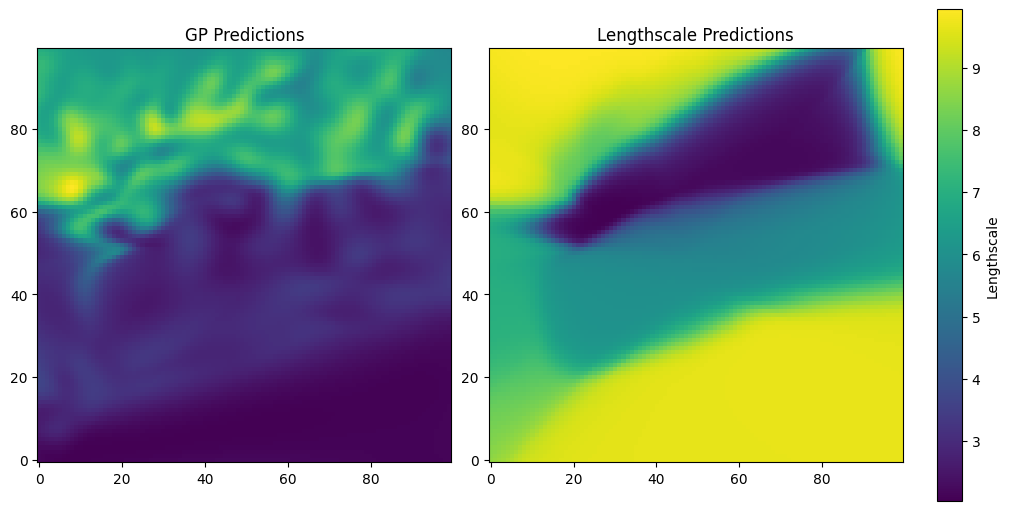

In [4]:
# Plot GP prediction and lengthscale map
X_test, _ = dataset.get_test()
grid_x, grid_y = np.mgrid[min(X_test[:, 0]):max(X_test[:, 0]):100j, 
                          min(X_test[:, 1]):max(X_test[:, 1]):100j]
X_test = np.stack([grid_x, grid_y], axis=-1)
x_dim, y_dim = X_test.shape[:2]
X_test = X_test.reshape(-1, 2).astype(X_train.dtype)

mean, std = model.predict_f(X_test)
lengthscale_preds = predict_lengthscales(X_test, lengthscales, kernel)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, origin="lower")
axes[0].set_title("GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — test data
sc2 = axes[1].imshow(lengthscale_preds.reshape(x_dim, y_dim).T, origin="lower")
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()

In [12]:
import numpy as np
from joblib import Parallel, delayed
from scipy.spatial.distance import cdist


def _gain_for_idx(idx, coverages, current_coverage):
    """
    Compute marginal gain for candidate `idx` given current_coverage.
    """
    gain_mask = coverages[idx] & ~current_coverage
    return int(gain_mask.sum())


def greedy_coverage(
    candidates,
    lengthscales,
    env,
    env_lengthscales,
    target_mean,
    n_jobs=-1,
    max_selections=None,
):
    """
    Greedy maximization of coverage area.

    For candidate i and env point j, j is covered by i iff ALL of:

        1) distance d = ||candidates[i] - env[j]|| <= lengthscale[i]
           (env point lies within a circle of radius = lengthscale[i])

        2) env_lengthscale[j] >  lengthscale[i] - 1

        3) env_lengthscale[j] <  lengthscale[i] + 1

    i.e. env_lengthscale[j] is within (lengthscale[i] - 1, lengthscale[i] + 1)
         AND env[j] is inside the circle of radius lengthscale[i].

    Parameters
    ----------
    candidates : ndarray (n, d)
    lengthscales : ndarray (n,)
        lengthscales (radius) at each candidate location
    env : ndarray (v, d)
    env_lengthscales : ndarray (v,)
        lengthscales at each env location
    target_mean : float in [0,1]
    n_jobs : int
    max_selections : int or None

    Returns
    -------
    X_sel : ndarray (k, d)
    selected_idxs : list[int]
    coverage_maps : list of boolean masks
    """
    n = len(candidates)
    if max_selections is None:
        max_selections = n

    lengthscales = np.asarray(lengthscales, dtype=float)
    env_lengthscales = np.asarray(env_lengthscales, dtype=float)

    if env_lengthscales.shape[0] != env.shape[0]:
        raise ValueError("env_lengthscales must have shape (v,) matching env.shape[0].")

    # ---------- Precompute all coverages ----------
    # distances: shape (n_candidates, n_env)
    dist_mat = cdist(candidates, env)

    # Condition 1: within circle of radius = lengthscale[i]
    within_circle = dist_mat <= lengthscales[:, None]

    # Condition 2: env_lengthscale[j] > lengthscale[i] - 1
    cond_lower = env_lengthscales[None, :] > (lengthscales[:, None] - 0.2)

    # Condition 3: env_lengthscale[j] < lengthscale[i] + 1
    cond_upper = env_lengthscales[None, :] < (lengthscales[:, None] + 0.2)

    # Final coverage mask: all three conditions
    coverages = (within_circle & cond_lower & cond_upper).astype(bool)

    del dist_mat, within_circle, cond_lower, cond_upper

    v = env.shape[0]
    target_sum = v * float(target_mean)

    # ---------- Greedy loop setup ----------
    selected_mask = np.zeros(n, dtype=bool)
    selected = []
    coverage_maps = []

    current_coverage = np.zeros(v, dtype=bool)
    current_sum = 0

    # ---------- Pure greedy loop ----------
    while current_sum < target_sum and len(selected) < max_selections:

        remaining_idxs = np.where(~selected_mask)[0]
        if remaining_idxs.size == 0:
            break

        gains = Parallel(n_jobs=n_jobs)(
            delayed(_gain_for_idx)(idx, coverages, current_coverage)
            for idx in remaining_idxs
        )
        gains = np.asarray(gains, dtype=int)

        best_pos = int(np.argmax(gains))
        best_gain = int(gains[best_pos])
        best_idx = int(remaining_idxs[best_pos])

        if best_gain <= 0:
            break

        # commit
        y_cov = coverages[best_idx]
        current_coverage |= y_cov
        current_sum = int(current_coverage.sum())

        selected_mask[best_idx] = True
        selected.append(best_idx)
        coverage_maps.append(y_cov)

        if current_sum >= target_sum:
            break

    X_sel = candidates[selected]
    return X_sel, selected, coverage_maps


# ---------------- Generate X_candidates (grid with spacing set to minimum radius) ----------------

radii = predict_lengthscales(X_train, lengthscales, kernel)/2
min_r = np.min(radii) * 0.5
x_max, y_max = X_train.max(axis=0)
x_min, y_min = X_train.min(axis=0)

# Define the number of points in each dimension
num_points_x = np.ceil((x_max-x_min)/min_r).astype(int)
num_points_y = np.ceil((y_max-y_min)/min_r).astype(int)

# Create 1D arrays for x and y coordinates
x_coords = np.linspace(x_min, x_max, num_points_x)
y_coords = np.linspace(y_min, y_max, num_points_y)

# Generate the 2D grid coordinates
xx, yy = np.meshgrid(x_coords, y_coords)
X_candidates = np.stack([xx.ravel(), yy.ravel()], axis=-1)
X_candidates = X_candidates.astype(X_train.dtype)
print(f"Num candidates: {len(X_candidates)}")

# ---------------- Get lengthscales ----------------
candidate_ls = predict_lengthscales(X_candidates, lengthscales, kernel) / 2.0
env_ls       = predict_lengthscales(X_test, lengthscales, kernel) / 2.0

X_sol, idxs, maps = greedy_coverage(
    candidates=X_candidates,
    lengthscales=candidate_ls,
    env=X_test,
    env_lengthscales=env_ls,
    target_mean=1.0,
    n_jobs=-1,
    max_selections=None,
)

print(f"Num sol: {len(X_sol)}")
print(f"Num uncovered: {len(np.where(np.sum(maps, axis=0)==0)[0])}")

Num candidates: 4624
Num sol: 262
Num uncovered: 0


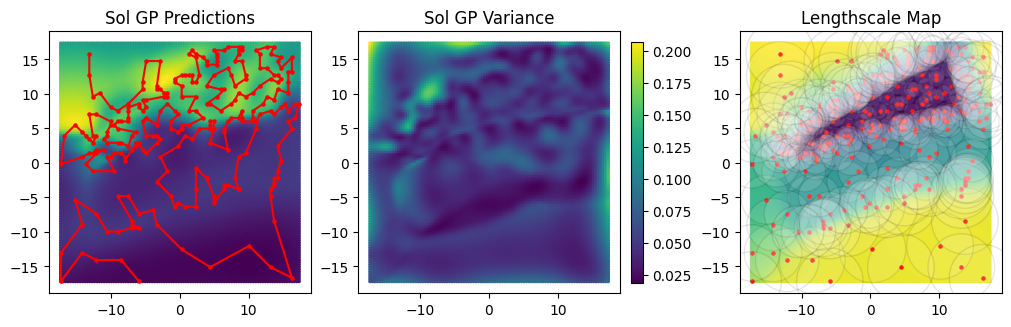

In [13]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    max_steps=0,
    return_model=True,
    verbose=False)
mean, var = model_sol.predict_f(X_test)

sol_path, _ = run_tsp(X_sol, time_limit=20)
sol_lengthscales = predict_lengthscales(X_sol, lengthscales, kernel)

fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].scatter(X_test[:, 0], X_test[:, 1], c=mean.numpy(), s=3)
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[0].plot(sol_path[0][:, 0], sol_path[0][:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — variance
sc2 = axes[1].scatter(X_test[:, 0], X_test[:, 1], c=var.numpy(), s=3)
#axes[1].scatter(X_candidates[:, 0], X_candidates[:, 1], c='r', s=1)
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

# Fix colorbar size
cbar = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

# Third subplot — lengthscale
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=env_ls, s=3)
axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[2].set_title("Lengthscale Map")
axes[2].set_aspect('equal')

for pt, d in zip(X_sol, sol_lengthscales):
    circle = patches.Circle(pt, 
                            d/2, 
                            edgecolor='k', 
                            facecolor='w', 
                            alpha=0.1)
    axes[2].add_patch(circle)

axes[2].set_xlim(axes[0].get_xlim())
axes[2].set_ylim(axes[0].get_ylim())

plt.show()